In [1]:
import numpy as np
import xspec

xspec.AllData.clear()
xspec.AllModels.clear()

xspec.Xset.restore("model.xcm")

xspec.Fit.statMethod = ("cstat")
xspec.Fit.bayes = "on"

xspec_observation = xspec.Spectrum(
    "spectrum_raw.pha"
)
xspec_observation.background = None

low_energy, high_energy = 0.3, 12.
xspec_observation.ignore(f"0.0-{low_energy:.1f} {high_energy:.1f}-**")

xspec_model = xspec.AllModels(1)
xspec_model.show()

 Solar Abundance Vector set to wilm:  Wilms, J., Allen, A. & McCray, R. ApJ 542 914 (2000) (abundances are set to zero for those elements not included in the paper).
 Cross Section Table set to vern:  Verner, Ferland, Korista, and Yakovlev 1996
Parameter delta values for fits will now be 0.01 * parValue

 The default systematic error for models is set to 0

tbvabs Version 2.3
Cosmic absorption with grains and H2, modified from
Wilms, Allen, & McCray, 2000, ApJ 542, 914-924
Questions: Joern Wilms
joern.wilms@sternwarte.uni-erlangen.de
joern.wilms@fau.de

http://pulsar.sternwarte.uni-erlangen.de/wilms/research/tbabs/

PLEASE NOTICE:
To get the model described by the above paper
you will also have to set the abundances:
   abund wilm

Note that this routine ignores the current cross section setting
as it always HAS to use the Verner cross sections as a baseline.
Reading APEC data from 3.0.9


Model TBabs<1>(bapec<2> + bapec<3>) Source No.: 1   Active/Off
Model Model Component  Parameter  

In [2]:
from bsixsa.convenience import set_prior_and_build_transform

define_prior = [
    ("bapec", "kT", 3, 6, "uniform"),
    ("bapec", "Abundanc", 0.5, 2.5, "uniform"),
    ("bapec", "Redshift", 0., 0.05, "uniform"),
    ("bapec", "Velocity", 50, 200, "uniform"),
    ("bapec", "norm", 0.5, 1.5, "loguniform"),
    ("bapec_3", "kT", 1, 4, "uniform"),
    ("bapec_3", "Abundanc", 0.5, 2.5, "uniform"),
    ("bapec_3", "Redshift", 0., 0.05, "uniform"),
    ("bapec_3", "Velocity", 50, 200, "uniform"),
    ("bapec_3", "norm", 1, 2, "loguniform")
]

transformations = set_prior_and_build_transform(xspec_model, define_prior)


Fit statistic  : C-Statistic                22788.62     using 19094 bins.
   (Includes a Bayesian contribution of 2.77)

Test statistic : Chi-Squared                19996.91     using 19094 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 2.08e-06 with 19084 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : C-Statistic                22788.98     using 19094 bins.
   (Includes a Bayesian contribution of 3.14)

Test statistic : Chi-Squared                19996.91     using 19094 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 2.08e-06 with 19084 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : C-Statistic                22781.16     using 19094 bins.
   (Includes a Bayesian contribution of -4.69)

Test statistic : Chi-Squared              

In [3]:
from bsixsa import SIXSASolver

outputfiles_basename = "sixsa_result_mri/"

solver = SIXSASolver(
    transformations,
    outputfiles_basename=outputfiles_basename,
    use_background=False
)

In [4]:
import matplotlib.pyplot as plt
from xspec import Plot

Plot.device = "/null"
Plot.xAxis="keV"
Plot("data")
energies = Plot.x()
edeltas = Plot.xErr()
rates = Plot.y()
errors = Plot.yErr()
labels = Plot.labels()


***Warning: Fit is not current.


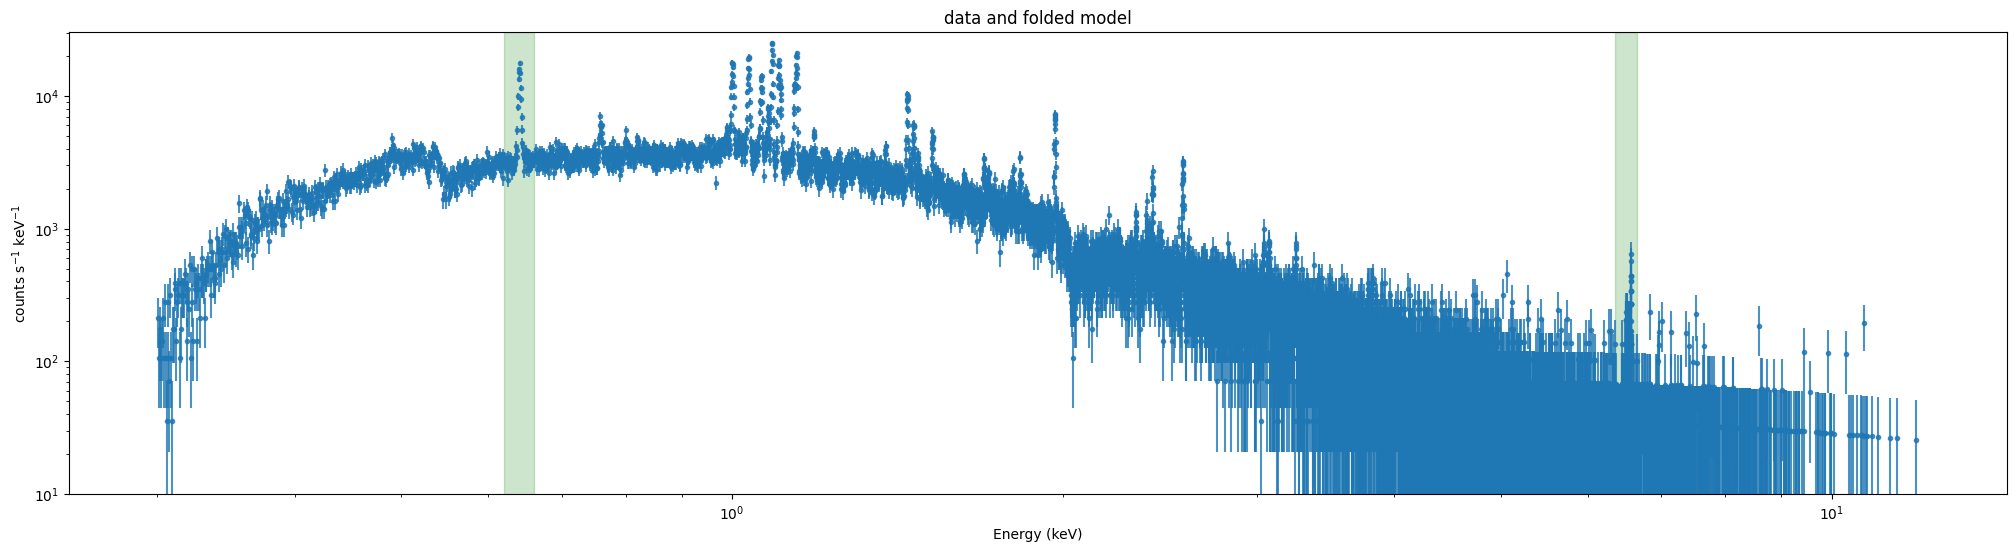

In [5]:
#complex_list = [[0.62, 0.66, 20], [0.73, 0.85, 12], [0.9, 1.2, 30], [1.3, 2, 70], [2.2, 2.7, 50], [6.35, 6.65, 30]]
complex_list = [[0.62, 0.66, 2], [6.35, 6.65, 2]] #[0.95, 1.2, 2],
%matplotlib inline

plt.close()
plt.figure(figsize=(25,6))
#plt.xscale('linear')
plt.xlabel(labels[0])
plt.ylabel(labels[1])
plt.title(labels[2])
plt.ylim(bottom=1e1, top=1.2*np.asarray(rates).max())
plt.errorbar(energies,rates,xerr=edeltas,yerr=errors,fmt='.', alpha=0.8)
plt.loglog()

for e_low, e_high, n_bins in complex_list:
    max_y = 1.2*np.asarray(rates).max()

    plt.fill_betweenx(
        np.asarray([0., max_y]),
        e_low,
        e_high,
        alpha=0.2,
        color='green'
    )

    if n_bins>2:

        x_lines = np.linspace(e_low, e_high, n_bins)

        for x in x_lines:
            plt.axvline(x, 1e-3, max_y, color='black', linestyle="dotted")

#plt.savefig("test.pdf", bbox_inches="tight")

In [6]:
from bsixsa.summary_stats import merge_summary, summary_statistics_func

energy_spectrum = np.asarray(xspec.AllData(1).energies).T

def full_spectrum_statistics_func(spectra):
    return summary_statistics_func(spectra, energy_grid=np.geomspace(energy_spectrum.min(), energy_spectrum.max(), 50))

summary_list = [full_spectrum_statistics_func]

for low_energy, high_energy, num_interval in complex_list:

    def summary_loc(spectra, low_energy=low_energy, high_energy=high_energy, num_interval=num_interval):
        return summary_statistics_func(
            spectra,
            energy_grid=np.linspace(low_energy, high_energy, num_interval),
            with_ratio=False,
            with_diff=False
        )

    summary_list.append(summary_loc)

embedding_func = merge_summary(*summary_list)

In [8]:
training_kwargs = dict(
    discard_prior_samples=True,
    force_first_round_loss=True,
    retrain_from_scratch=False,
    training_batch_size=256
)

posterior = solver.run(num_rounds=5, num_simulations=5_000, training_kwargs=training_kwargs, embedding=embedding_func, prune_summaries=True)

Round 1 - Folding model:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 36 epochs.

Round 2 - Folding model:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 36 epochs.

Round 3 - Folding model:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 36 epochs.

Round 4 - Folding model:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 31 epochs.

Round 5 - Folding model:   0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 29 epochs.

Computing posterior statistic - Folding model:   0%|          | 0/1000 [00:00<?, ?it/s]

/Users/sdupourque/PycharmProjects/BXA/src/bsixsa/priors.py:55: RuntimeWarning: overflow encountered in power
  def log_after_transform(x): return 10**x


   All chains are now removed.
  New chain sixsa_result_mri/chain.fits is now loaded.
  Default chain length is now set to length of sixsa_result_mri/chain.fits: 1000

Fit statistic  : C-Statistic                16157.89     using 19094 bins.
   (Includes a Bayesian contribution of 9.34)

Test statistic : Chi-Squared                13015.09     using 19094 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 1.00e+00 with 19084 degrees of freedom
 Current data and model not fit yet.


  0%|          | 0/100 [00:00<?, ?it/s]

The error "***XSPEC Error: Requested array does not exist for this plot." can be ignored.



***XSPEC Error: Requested array does not exist for this plot.


***Warning: Fit is not current.
***Warning: Fit is not current.


/Users/sdupourque/PycharmProjects/BXA/src/bsixsa/plotting_stuff.py:186: RuntimeWarning: divide by zero encountered in divide
  residuals = (total-y_observed)/(np.percentile(total, 84, axis=0) - np.percentile(total, 16, axis=0))
/Users/sdupourque/PycharmProjects/BXA/src/bsixsa/plotting_stuff.py:186: RuntimeWarning: invalid value encountered in divide
  residuals = (total-y_observed)/(np.percentile(total, 84, axis=0) - np.percentile(total, 16, axis=0))
/Users/sdupourque/miniforge3/envs/BXA/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/sdupourque/miniforge3/envs/BXA/lib/python3.12/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/Users/sdupourque/miniforge3/envs/BXA/lib/python3.12/site-packages/numpy/lib/function_base.py:4658: RuntimeWarning: invalid value encountered in subt

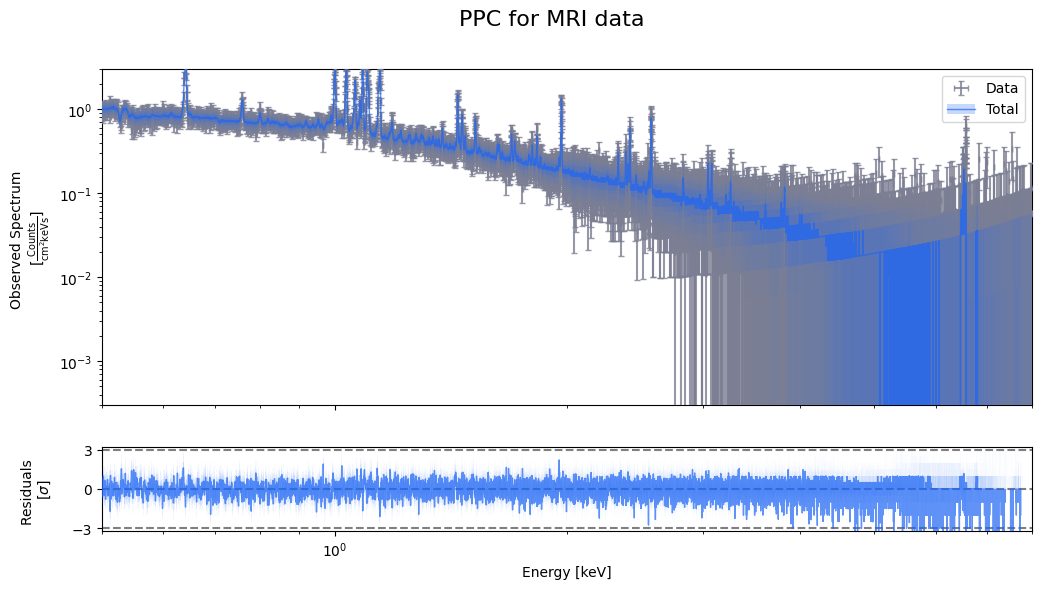

In [9]:
import importlib
import bsixsa
importlib.reload(bsixsa)
from bsixsa.plotting_stuff import plot_ppc
importlib.reload( bsixsa.plotting_stuff)
from bsixsa.plotting_stuff import plot_ppc
component_names = ["Total"]

fig = plot_ppc(solver, component_names=component_names, x_lim=(0.5, 8), y_lim=(3e-4, 3), plot_background=False)
fig.suptitle("PPC for MRI data", fontsize=16);

  0%|          | 0/100 [00:00<?, ?it/s]

The error "***XSPEC Error: Requested array does not exist for this plot." can be ignored.



***XSPEC Error: Requested array does not exist for this plot.


***Warning: Fit is not current.
***Warning: Fit is not current.


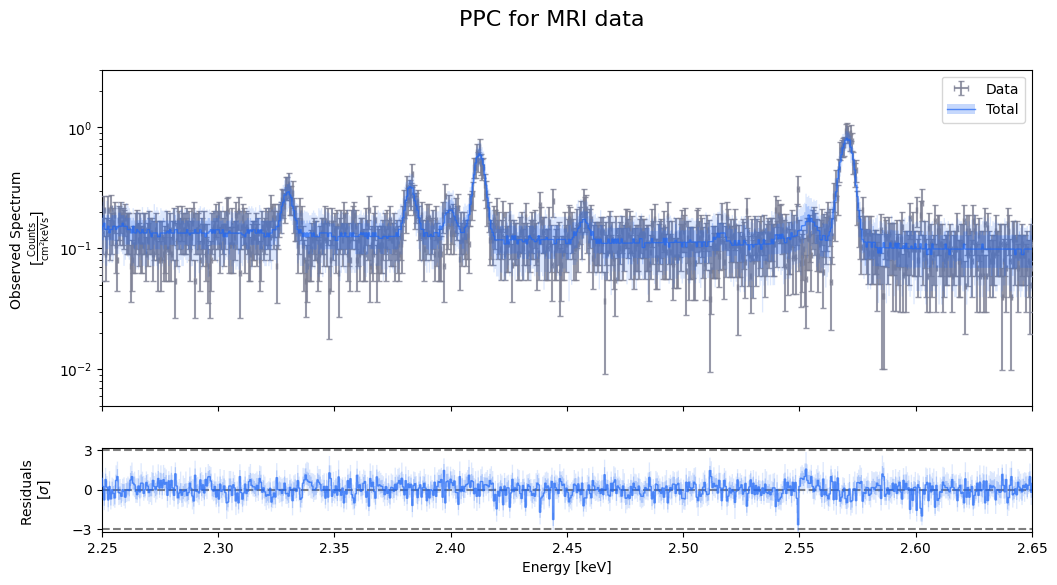

In [10]:
fig = plot_ppc(solver, component_names=component_names, x_lim=(2.25, 2.65), y_lim=(5e-3, 3), plot_background=False)
plt.xscale('linear')
fig.suptitle("PPC for MRI data", fontsize=16);

  0%|          | 0/100 [00:00<?, ?it/s]

The error "***XSPEC Error: Requested array does not exist for this plot." can be ignored.



***XSPEC Error: Requested array does not exist for this plot.


***Warning: Fit is not current.
***Warning: Fit is not current.


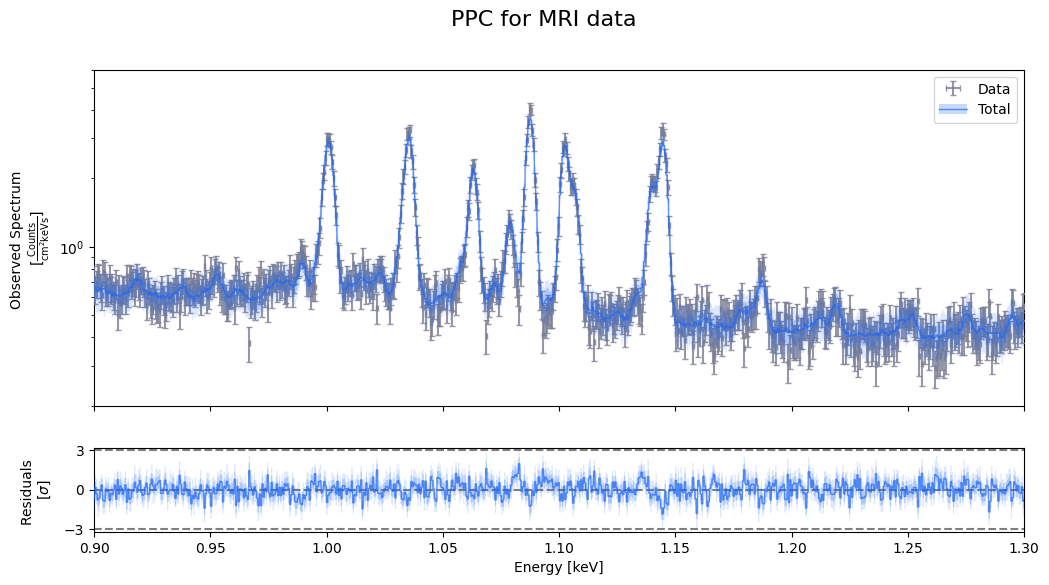

In [11]:
fig = plot_ppc(solver, component_names=component_names, x_lim=(0.9, 1.3), y_lim=(2e-1, 6), plot_background=False)
plt.xscale('linear')
fig.suptitle("PPC for MRI data", fontsize=16);

  0%|          | 0/100 [00:00<?, ?it/s]

The error "***XSPEC Error: Requested array does not exist for this plot." can be ignored.



***XSPEC Error: Requested array does not exist for this plot.


***Warning: Fit is not current.
***Warning: Fit is not current.


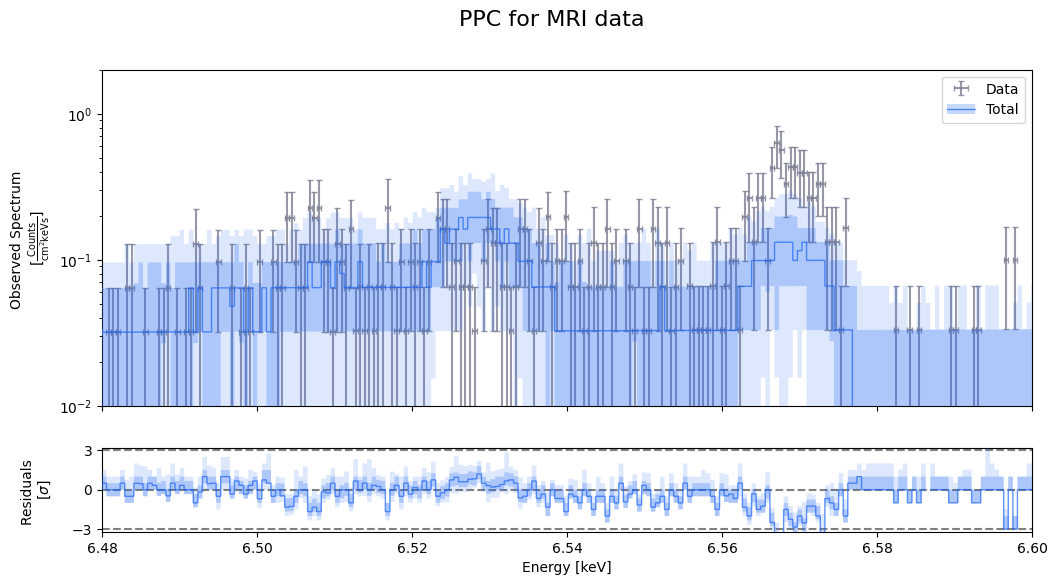

In [12]:
fig = plot_ppc(solver, component_names=component_names, x_lim=(6.48, 6.60), y_lim=(1e-2, 2), plot_background=False)
plt.xscale('linear')
fig.suptitle("PPC for MRI data", fontsize=16);

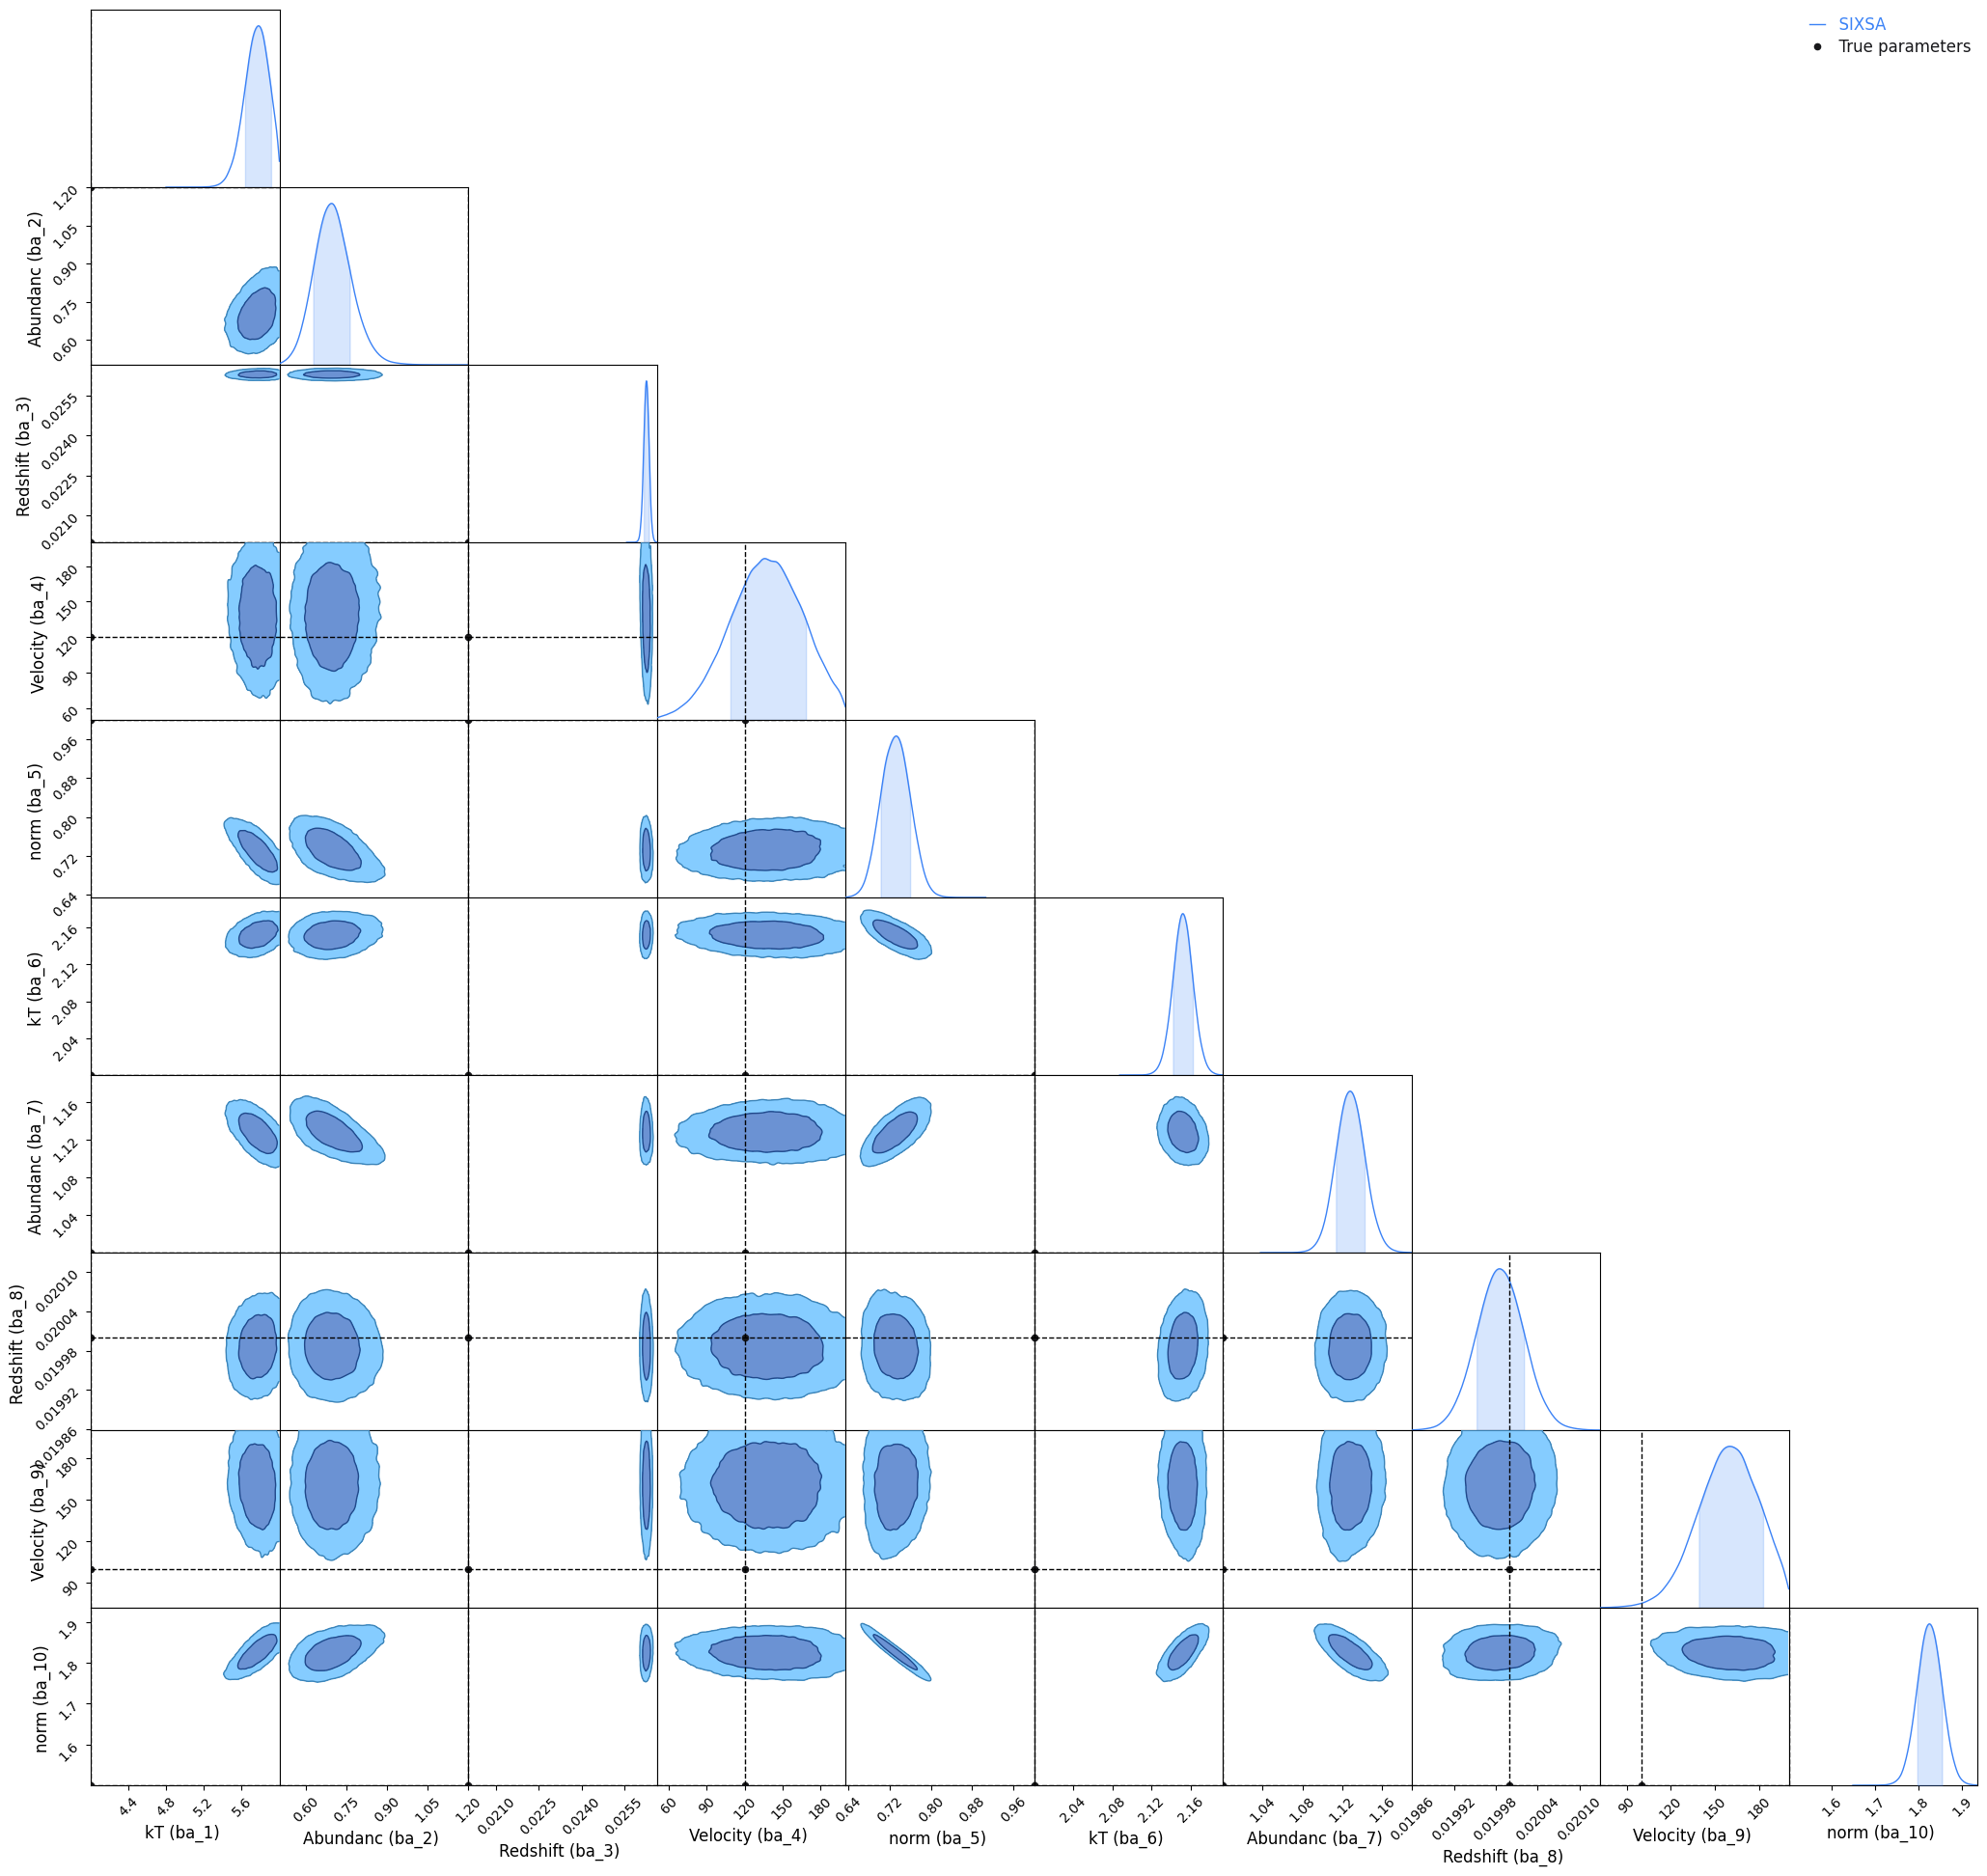

In [13]:
%matplotlib inline

import pandas as pd
import numpy as np
from generate_ref_spectrum import truth

from chainconsumer import Chain, ChainConsumer, Truth

indexes = np.sort([t['index'] for t in solver.transformations])
parameter_names = np.asarray(solver.parameter_names_uniques)[indexes-1]

samples = posterior.sample((100000,))
warped_samples = solver.unit_cube_to_xspec(samples.numpy().T)

dict_of_params = {}

for i in indexes:
    name = solver.parameter_names_uniques[i-1]
    dict_of_params[name] = np.asarray([warped_samples[j][i] for j in range(len(warped_samples))])

cc = ChainConsumer()
chain = Chain(samples=pd.DataFrame.from_dict(dict_of_params), name="SIXSA")

truth = [truth[t["index"]] for t in solver.transformations]
truth_loc = {name:truth[i] for i, name in enumerate(parameter_names)}

cc.add_chain(chain)
#cc.add_chain(xspec_cov)
cc.add_truth(Truth(location=truth_loc, color="black"))
cc.add_marker(location=truth_loc, name="True parameters", color="black", marker_style="o", marker_size=20)
cc.plotter.plot();

In [15]:
pd.DataFrame.from_dict(dict_of_params).to_csv("results_df/sixsa_mri_summary.csv")

In [14]:
xspec.Fit.perform()

                                   Parameters
C-Statistic  |beta|/N    Lvl          2:kT    3:Abundanc    4:Redshift    5:Velocity        6:norm          7:kT    8:Abundanc    9:Redshift   10:Velocity       11:norm
15547.9      106570       -3       4.42599      0.912502     0.0199567       190.537       1.01952       2.05281       1.11011     0.0200035       116.273       1.51777
15523.4      6625.84      -4       4.05240      0.944600     0.0200858       54.9924       1.20008       1.99784       1.14378     0.0199970       108.378       1.32593
15500.8      12995.2      -5       4.05598       1.01268     0.0199961       111.911       1.22033       1.98519       1.12366     0.0200076       101.130       1.30168
15499        1464.86      -6       4.07000       1.06264     0.0199611       103.703       1.21288       1.97773       1.10048     0.0200187       98.1574       1.30785
15499        282.429      -7       4.04828       1.06162     0.0199600       102.154       1.22474       1.97

In [15]:
posterior_unit_cube = posterior.sample((10_000,)).numpy().T
posterior_bxa = solver.prior_function(posterior_unit_cube)
posterior_xspec = solver.unit_cube_to_xspec(posterior_unit_cube)
posterior_sims = solver.simulate(posterior_xspec, return_stat=False, desc="Computing posterior statistic - ")

Computing posterior statistic - Folding model:   0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 